# COVID-19 Data analysis & visualization

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from datetime import datetime, date, time, timedelta
from scipy import stats
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', 50)

In [2]:
# download the most recent COVID-19 dataset with wget using quite mode, timestamp (to only get the version diferent from local), and output directory
!wget -qNP data https://github.com/owid/covid-19-data/raw/master/public/data/owid-covid-data.xlsx

In [3]:
import platform
from pathlib import Path, PureWindowsPath
# linux path
filename = Path("data/owid-covid-data.xlsx").resolve()
# windows path 
if platform.system() == 'Windows':
    filename = PureWindowsPath(filename)

### I. Worldwide

In [4]:
# initial date to start analysis with
begin_date = datetime.strptime('20-02-2020', '%d-%m-%Y')
end_date = date.today()

In [11]:
countries = ['Netherlands', 'Belgium', 'Germany', 'France']

In [12]:
df_world = pd.read_excel(filename, index_col="date", parse_dates=True)
df = df_world[df_world['location'].isin(countries)]
df.index = df.index.date
df.drop_duplicates('location', keep='last')

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,positive_rate,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
2020-10-21,BEL,Europe,Belgium,267443.0,10271.0,10129.714,10540.0,42.0,36.571,23076.088,886.224,874.034,909.435,3.624,3.156,4367693.0,78078.0,376.863,6.737,64376.0,5.555,6.355,0.157,tests performed,52.78,11589616.0,375.564,41.8,18.571,12.849,42658.576,0.2,114.898,4.29,25.1,31.4,NaN,5.64,81.63,0.916
2020-10-23,DEU,Europe,Germany,403291.0,11242.0,7819.143,9954.0,49.0,31.429,4813.464,134.178,93.325,118.806,0.585,0.375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83783945.0,237.016,46.6,21.453,15.957,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.00,81.33,0.936
2020-10-23,FRA,Europe,France,999043.0,41622.0,27051.286,34210.0,162.0,155.000,15305.489,637.655,414.430,524.102,2.482,2.375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65273512.0,122.578,42.0,19.718,13.079,38605.671,NaN,86.060,4.77,30.1,35.6,NaN,5.98,82.66,0.901
2020-10-23,NLD,Europe,Netherlands,262109.0,9268.0,8342.429,6909.0,46.0,32.286,15296.816,540.885,486.868,403.213,2.685,1.884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17134873.0,508.544,43.2,18.779,11.881,48472.545,NaN,109.361,5.29,24.4,27.3,NaN,3.32,82.28,0.931


In [13]:
print(f"Total cases per million per country as for {df.index[-1]}:")
print(f"{df.groupby('location')['total_cases_per_million'].agg('last').to_string()}")
print('\n')
print(f"Total deaths per million per country as for {df.index[-1]}:")
print(f"{df.groupby('location')['total_deaths_per_million'].agg('last').to_string()}")

Total cases per million per country as for 2020-10-23:
location
Belgium        23076.088
France         15305.489
Germany         4813.464
Netherlands    15296.816


Total deaths per million per country as for 2020-10-23:
location
Belgium        909.435
France         524.102
Germany        118.806
Netherlands    403.213


In [14]:
df['mortality_rate'] = df['new_deaths'] / df['new_cases']
df['mortality_rate_per_million'] = df['new_deaths_per_million'] / df['new_cases_per_million']

In [15]:
def dfplot(metric, title, xlabel, ylabel, logy=False):
    fig, ax = plt.subplots(figsize=(15, 5))
    df[df.index > begin_date.date()].groupby('location')[metric].plot(ax=ax, legend=True, fontsize=14, logy=logy)
    plt.legend(loc=2, prop={'size': 14})
    plt.title(title, fontweight="bold")
    plt.xlabel(xlabel, fontsize=14, fontweight="bold")
    plt.ylabel(ylabel, fontsize=14, fontweight="bold")
    plt.grid(axis='y')  
    #set ticks every week
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    #set major ticks format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b 2020'))
    fig.autofmt_xdate()
    plt.show()

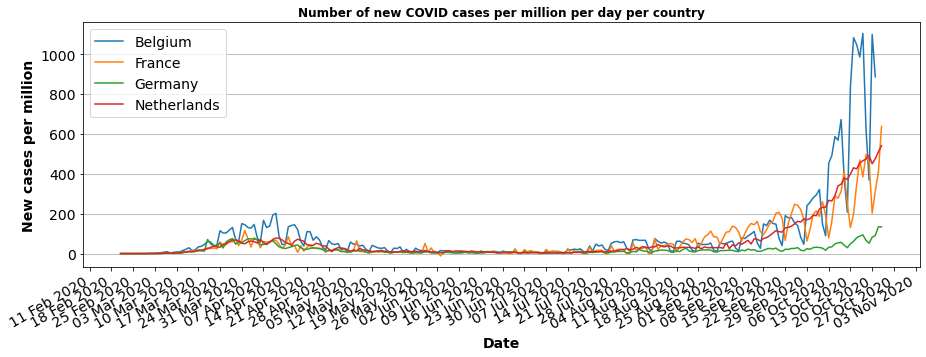

In [16]:
dfplot('new_cases_per_million', title="Number of new COVID cases per million per day per country", xlabel='Date', ylabel='New cases per million', logy=False)

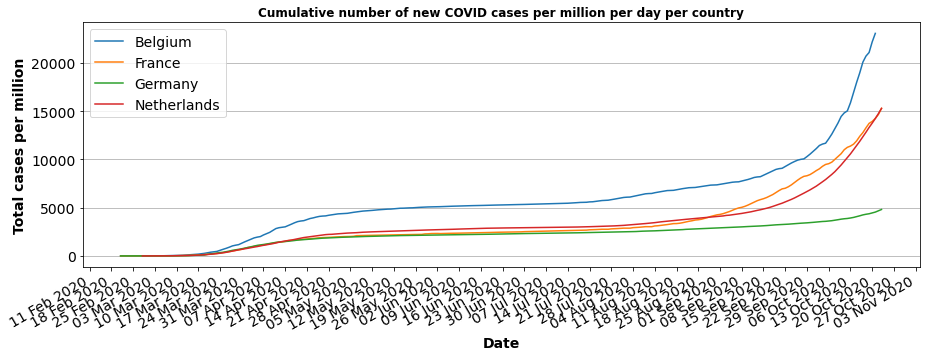

In [17]:
dfplot('total_cases_per_million', title="Cumulative number of new COVID cases per million per day per country", xlabel='Date', ylabel='Total cases per million')

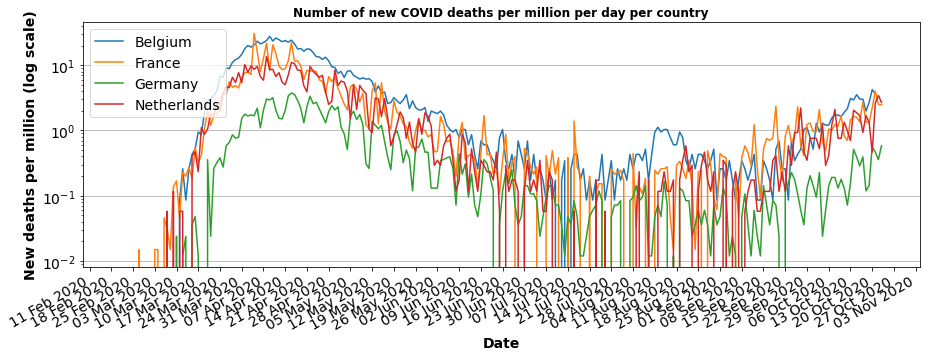

In [18]:
dfplot('new_deaths_per_million', title="Number of new COVID deaths per million per day per country", xlabel='Date', ylabel='New deaths per million (log scale)', logy=True)

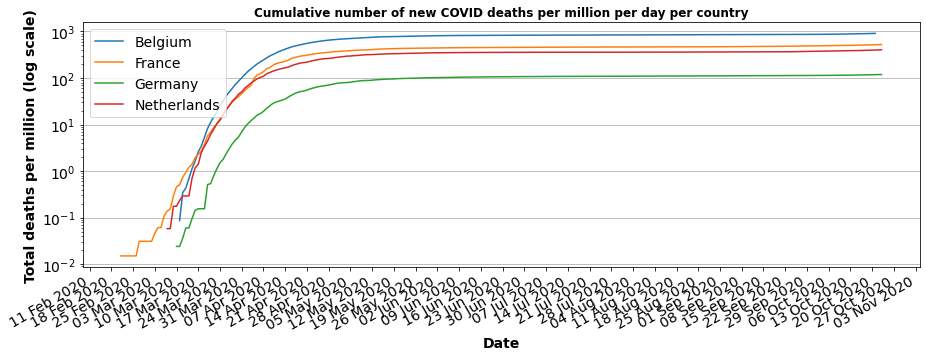

In [19]:
dfplot('total_deaths_per_million', title="Cumulative number of new COVID deaths per million per day per country", xlabel='Date', ylabel='Total deaths per million (log scale)', logy=True)

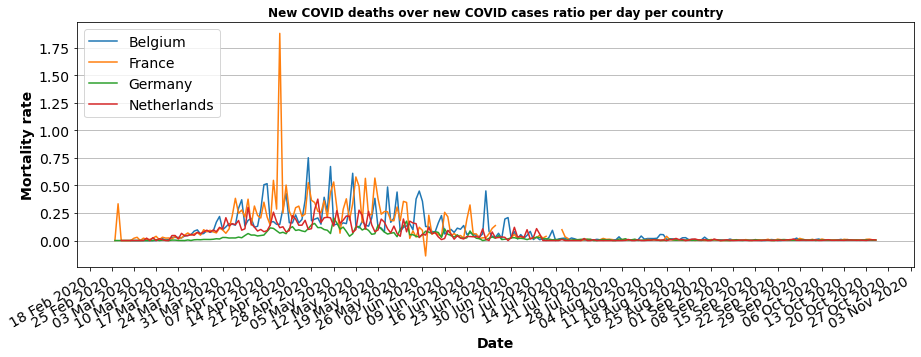

In [20]:
dfplot('mortality_rate', title="New COVID deaths over new COVID cases ratio per day per country", xlabel='Date', ylabel='Mortality rate')

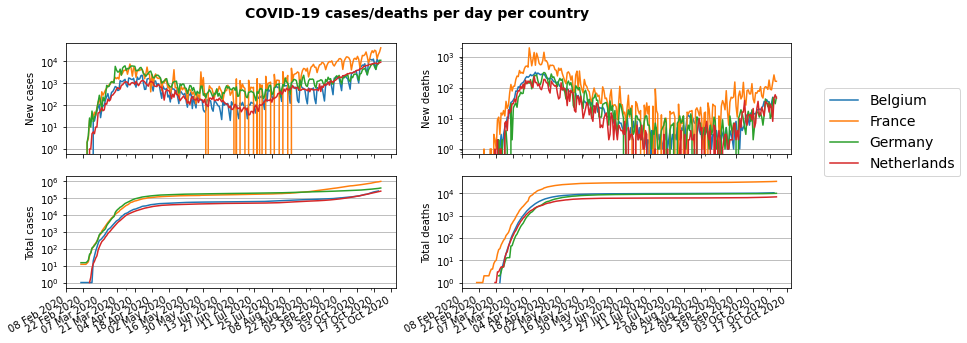

In [21]:
# combine altogether
fig, axs = plt.subplots(2, 2, sharex='col', sharey=False, figsize=(13,5))
(ax1, ax2), (ax3, ax4) = axs
df[df.index > begin_date.date()].groupby('location')['new_cases'].plot(ax=ax1, legend=False, fontsize=14, logy=True)
df[df.index > begin_date.date()].groupby('location')['new_deaths'].plot(ax=ax2, legend=False, fontsize=14, logy=True)
df[df.index > begin_date.date()].groupby('location')['total_cases'].plot(ax=ax3, legend=False, fontsize=14, logy=True)
df[df.index > begin_date.date()].groupby('location')['total_deaths'].plot(ax=ax4, legend=False, fontsize=14, logy=True)
ax1.grid(axis='y'); ax2.grid(axis='y'); ax3.grid(axis='y'); ax4.grid(axis='y')
labels = ['New cases', 'New deaths', 'Total cases', 'Total deaths']
for ax, label in zip(axs.flat, labels):
    ax.set(ylabel=label)
    xstart, xend = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(xstart, xend, 14))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b 2020'))
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10))
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(10)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(10)
plt.rc('axes', labelsize=12)
plt.legend(loc=(1.1, 1.0), prop={'size': 14})
fig.suptitle('COVID-19 cases/deaths per day per country', fontsize=14, fontweight="bold")
fig.autofmt_xdate()
plt.show()

In [22]:
def myLogFormat(y,pos):
    # Find the number of decimal places required
    decimalplaces = int(np.maximum(-np.log10(y),0))     # =0 for numbers >=1
    # Insert that number into a format string
    formatstring = '{{:.{:1d}f}}'.format(decimalplaces)
    # Return the formatted tick label
    return formatstring.format(y)

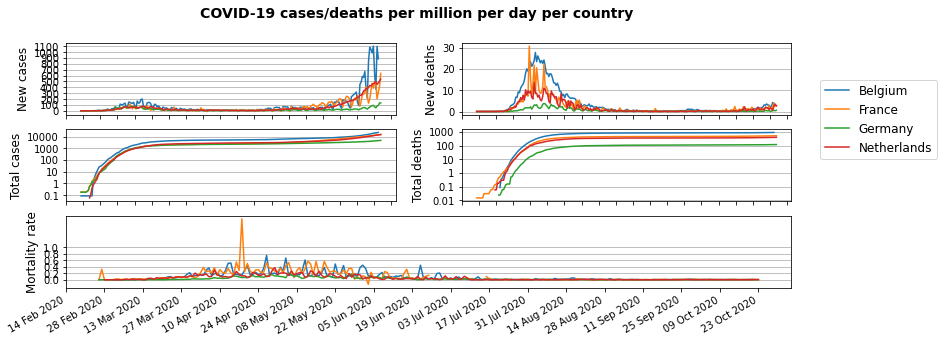

In [23]:
# combine altogether
fig = plt.figure(constrained_layout=True, figsize=(13, 5))
grid = fig.add_gridspec(nrows=3, ncols=2, wspace=0.2, hspace=0.2)
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[0, 1])
ax3 = fig.add_subplot(grid[1, 0])
ax4 = fig.add_subplot(grid[1, 1])
ax5 = fig.add_subplot(grid[2, :])
df[df.index > begin_date.date()].groupby('location')['new_cases_per_million'].plot(ax=ax1, legend=False, fontsize=14, logy=False)
df[df.index > begin_date.date()].groupby('location')['new_deaths_per_million'].plot(ax=ax2, legend=False, fontsize=14, logy=False)
df[df.index > begin_date.date()].groupby('location')['total_cases_per_million'].plot(ax=ax3, legend=False, fontsize=14, logy=True)
df[df.index > begin_date.date()].groupby('location')['total_deaths_per_million'].plot(ax=ax4, legend=False, fontsize=14, logy=True)
df[df.index > begin_date.date()].groupby('location')['mortality_rate_per_million'].plot(ax=ax5, legend=False, fontsize=14, logy=False)
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
# ax5.text(df.index.max()+timedelta(days=30), 0.5,
#          'Mortality rate =\n new deaths / cases', ha="center", va="center", size=12,
#         bbox=bbox_props)
ax1.grid(axis='y'); ax2.grid(axis='y'); ax3.grid(axis='y'); ax4.grid(axis='y'); ax5.grid(axis='y')
axes = [ax1, ax2, ax3, ax4, ax5]
labels = ['New cases', 'New deaths', 'Total cases', 'Total deaths', 'Mortality rate']
for ax, label in zip(axes, labels):
    ax.set_ylabel(label)
    xstart, xend = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(xstart, xend, 14))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b 2020'))
    if ax == ax1:
        ax.yaxis.set_major_locator(ticker.MultipleLocator(base=100))
    elif ax == ax2:
        ax.yaxis.set_major_locator(ticker.MultipleLocator(base=10))
    elif ax in [ax3, ax4]:
        ax.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=10))
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(myLogFormat))
    else:
        ax.yaxis.set_ticks(np.arange(0,1.1,0.2))
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(10)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(10)
plt.rc('axes', labelsize=12)
plt.legend(loc=(1.04, 1.78), prop={'size': 12})
fig.suptitle('COVID-19 cases/deaths per million per day per country', fontsize=14, fontweight="bold")
fig.autofmt_xdate()
# if platform.system() == 'Windows':
#     filename = "plots\covid-19_cases_per_day_per_country.pdf"
# else:
#     filename = "plots/covid-19_cases_per_day_per_country.pdf"
# plt.savefig(filename, papertype = 'a4', orientation = 'portrait', bbox_inches='tight')
plt.show()

In [26]:
countries = df_world[(df_world.new_cases.notnull()) & (df_world.index > begin_date) & (df_world.continent == 'Europe')].reset_index()
countries['date'] = countries.date.dt.strftime('%Y-%m-%d')

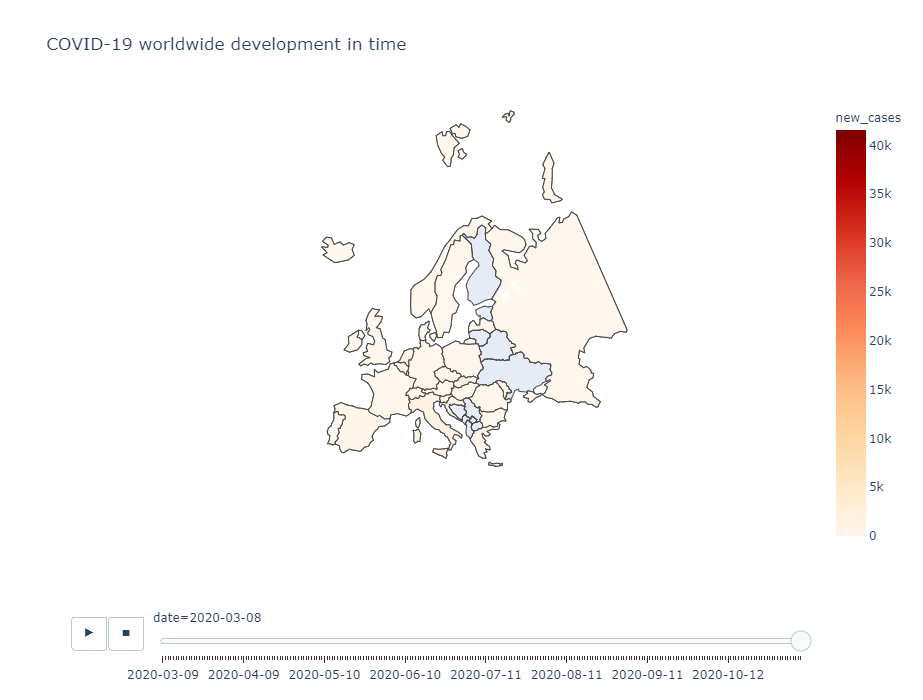

In [27]:
fig = px.choropleth(countries, locations="location",
                    locationmode="country names",
                    color="new_cases",
                    color_continuous_scale='OrRd', #px.colors.diverging.RdYlGn[::-1],
                    range_color=[0, np.max(countries.new_cases)],
                    animation_frame="date",
                    scope="europe",
                    title="COVID-19 worldwide development in time",
                    height=700)
fig.show()

# Predictive modelling

### I. Worldwide (regression)

In [28]:
df_w = df_world.drop_duplicates('location', keep='last')
df_w = df_w.reset_index()
df_w.drop('date', axis=1, inplace=True)
df_w = df_w.tail(-2) # remove World and International
df_w.head()

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,tests_per_case,positive_rate,tests_units,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
2,AGO,Africa,Angola,8338.0,289.0,213.143,255.0,4.0,4.000,253.695,8.793,6.485,7.759,0.122,0.122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32866268.0,23.890,16.8,2.405,1.362,5819.495,NaN,276.045,3.94,NaN,NaN,26.664,NaN,61.15,0.581
3,AIA,North America,Anguilla,3.0,0.0,0.000,NaN,0.0,0.000,199.973,0.000,0.000,NaN,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15002.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.88,NaN
4,ALB,Europe,Albania,18250.0,302.0,291.143,465.0,3.0,3.714,6341.650,104.941,101.169,161.582,1.042,1.291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2877800.0,104.871,38.0,13.188,8.643,11803.431,1.1,304.195,10.08,7.1,51.2,NaN,2.89,78.57,0.785
5,AND,Europe,Andorra,3811.0,0.0,88.714,63.0,0.0,0.571,49323.756,0.000,1148.182,815.376,0.000,7.396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77265.0,163.755,NaN,NaN,NaN,NaN,NaN,109.135,7.97,29.0,37.8,NaN,NaN,83.73,0.858
6,ARE,Asia,United Arab Emirates,120710.0,1578.0,1324.714,474.0,2.0,3.143,12204.764,159.549,133.939,47.925,0.202,0.318,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9890400.0,112.442,34.0,1.144,0.526,67293.483,NaN,317.840,17.26,1.2,37.4,NaN,1.20,77.97,0.863


In [29]:
df_w.columns

Index(['iso_code', 'continent', 'location', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index'],
      dtype='object')

In [30]:
df_w = df_w.drop(['iso_code', 'new_cases', 'total_deaths', 'new_deaths', 'total_cases_per_million', 
               'new_cases_per_million', 'total_deaths_per_million', 'new_deaths_per_million', 'new_tests', 
               'total_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'new_tests_smoothed', 
               'new_tests_smoothed_per_thousand', 'tests_units', 'stringency_index', 'tests_per_case', 
                  'positive_rate'], axis=1)
df_w.tail()

,continent,location,total_cases,new_cases_smoothed,new_deaths_smoothed,new_cases_smoothed_per_million,new_deaths_smoothed_per_million,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
208,Africa,South Africa,710515.0,1761.571,76.286,29.702,1.286,5.930869e+07,46.754,27.3,5.344,3.053,12294.876,18.9,200.380,5.52,8.100,33.200,43.993,2.320,64.13,0.699
209,Africa,Zambia,16035.0,53.714,0.000,2.922,0.000,1.838396e+07,22.995,17.7,2.480,1.542,3689.251,57.5,234.499,3.94,3.100,24.700,13.938,2.000,63.89,0.588
210,Africa,Zimbabwe,8242.0,23.857,0.714,1.605,0.048,1.486293e+07,42.729,19.6,2.822,1.882,1899.775,21.4,307.846,1.82,1.600,30.700,36.791,1.700,61.49,0.535
211,NaN,World,41771932.0,390097.429,5616.286,50.046,0.721,7.794799e+09,58.045,30.9,8.696,5.355,15469.207,10.0,233.070,8.51,6.434,34.635,60.130,2.705,72.58,NaN
212,NaN,International,696.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
print("% of nan values per column")
for column in df_w.columns:
    print(f"{column}: {df_w[column].isna().sum()} / {len(df_w)}")

% of nan values per column
continent: 2 / 211
location: 0 / 211
total_cases: 1 / 211
new_cases_smoothed: 2 / 211
new_deaths_smoothed: 2 / 211
new_cases_smoothed_per_million: 2 / 211
new_deaths_smoothed_per_million: 2 / 211
population: 1 / 211
population_density: 12 / 211
median_age: 25 / 211
aged_65_older: 28 / 211
aged_70_older: 26 / 211
gdp_per_capita: 28 / 211
extreme_poverty: 88 / 211
cardiovasc_death_rate: 25 / 211
diabetes_prevalence: 18 / 211
female_smokers: 70 / 211
male_smokers: 72 / 211
handwashing_facilities: 119 / 211
hospital_beds_per_thousand: 46 / 211
life_expectancy: 4 / 211
human_development_index: 31 / 211


In [32]:
X = df_w.drop('total_cases', axis=1)
y = df_w['total_cases']
y.fillna(0, inplace=True)

In [33]:
y.isnull().values.any()

False

In [34]:
X.head()

,continent,location,new_cases_smoothed,new_deaths_smoothed,new_cases_smoothed_per_million,new_deaths_smoothed_per_million,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
2,Africa,Angola,213.143,4.000,6.485,0.122,32866268.0,23.890,16.8,2.405,1.362,5819.495,NaN,276.045,3.94,NaN,NaN,26.664,NaN,61.15,0.581
3,North America,Anguilla,0.000,0.000,0.000,0.000,15002.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.88,NaN
4,Europe,Albania,291.143,3.714,101.169,1.291,2877800.0,104.871,38.0,13.188,8.643,11803.431,1.1,304.195,10.08,7.1,51.2,NaN,2.89,78.57,0.785
5,Europe,Andorra,88.714,0.571,1148.182,7.396,77265.0,163.755,NaN,NaN,NaN,NaN,NaN,109.135,7.97,29.0,37.8,NaN,NaN,83.73,0.858
6,Asia,United Arab Emirates,1324.714,3.143,133.939,0.318,9890400.0,112.442,34.0,1.144,0.526,67293.483,NaN,317.840,17.26,1.2,37.4,NaN,1.20,77.97,0.863


In [35]:
X.shape

(211, 21)

In [36]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 2 to 212
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   continent                        209 non-null    object 
 1   location                         211 non-null    object 
 2   new_cases_smoothed               209 non-null    float64
 3   new_deaths_smoothed              209 non-null    float64
 4   new_cases_smoothed_per_million   209 non-null    float64
 5   new_deaths_smoothed_per_million  209 non-null    float64
 6   population                       210 non-null    float64
 7   population_density               199 non-null    float64
 8   median_age                       186 non-null    float64
 9   aged_65_older                    183 non-null    float64
 10  aged_70_older                    185 non-null    float64
 11  gdp_per_capita                   183 non-null    float64
 12  extreme_poverty       

### Pair correlations

In [37]:
#sns.pairplot(X)

In [38]:
# column normalization
# X_norm = X
# for col in X.columns[2:]:
#     X_norm[col] = stats.boxcox(X[col])[0]
# sns.pairplot(X_norm)

### Model comparison

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

categorical_features = X.columns[0:2].tolist()
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_features = X.columns[2:].tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.65, random_state=42)

models = [DummyRegressor(), SGDRegressor(), ElasticNet()]

for model in models:
    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    rgr = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    rgr.fit(X_train, y_train)
    
    print(f"Best {model} score: {rgr.score(X_test, y_test):.3f}")

Best DummyRegressor() score: -0.001
Best SGDRegressor() score: 0.905
Best ElasticNet() score: 0.988


### Regressor score vs. test size

Best test size ratio is: 95.0%


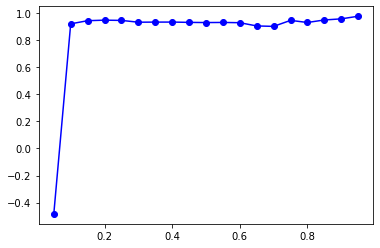

In [40]:
scores = []
sizes = np.linspace(0.05, 0.95, 19)
for size in sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=42)
    regressor = SGDRegressor()
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', regressor)]).fit(X_train, y_train)
    scores.append(pipe.score(X_test, y_test))
 
plt.plot(sizes, scores, '-bo')
print(f"Best test size ratio is: {sizes[np.argmax(scores)]*100}%")

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
parameters = {
             'regressor__loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
             'regressor__penalty': ['l2', 'l1', 'elasticnet'],
             'regressor__alpha': [0.0001, 0.001, 0.01],
             'regressor__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
             }
regressor = SGDRegressor()
pipe = Pipeline(steps=[('preprocessor', preprocessor), ('regressor',  regressor)])
gsrgr = GridSearchCV(pipe, parameters).fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % gsrgr.best_score_)
print(gsrgr.best_params_)
print('R2: ', r2_score(y_pred = gsrgr.predict(X_test), y_true = y_test))

Best parameter (CV score=-0.727):
{'regressor__alpha': 0.001, 'regressor__learning_rate': 'optimal', 'regressor__loss': 'epsilon_insensitive', 'regressor__penalty': 'l1'}
R2:  0.023477316983182006


In [42]:
regressor = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', SGDRegressor())]).fit(X_train, y_train)
print(f"Model score: {regressor.score(X_test, y_test):.3f}")
print('R2: ', r2_score(y_pred = regressor.predict(X_test), y_true = y_test))

Model score: 0.977
R2:  0.97696122995691


In [43]:
# Hyperparameter optimization across multiple models in scikit-learn
# http://www.davidsbatista.net/blog/2018/02/23/model_optimization/
class EstimatorSelectionHelper:
    
    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=2, n_jobs=2, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [44]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)])

X_train = preprocessor.fit_transform(X_train)

models = {
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'SVC': SVC()
}

params = {
    'ExtraTreesClassifier': { 'n_estimators': [16, 32] },
    'RandomForestClassifier': { 'n_estimators': [16, 32] },
    'AdaBoostClassifier':  { 'n_estimators': [16, 32] },
    'GradientBoostingClassifier': { 'n_estimators': [16, 32], 'learning_rate': [0.8, 1.0] },
    'SVC': [
        {'kernel': ['linear'], 'C': [1, 10]},
        {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.001, 0.0001]},
    ]
}

helper = EstimatorSelectionHelper(models, params)
helper.fit(X_train, y_train, scoring='accuracy')

helper.score_summary(sort_by='max_score')

Running GridSearchCV for ExtraTreesClassifier.
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    2.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for RandomForestClassifier.
Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   4 out of   4 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for AdaBoostClassifier.
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Running GridSearchCV for GradientBoostingClassifier.
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=2)]: Done   8 out of   8 | elapsed:    6.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Running GridSearchCV for SVC.
Fitting 2 folds for each of 6 candidates, totalling 12 fits
ExtraTreesClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier
SVC


[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:    0.2s finished


,estimator,min_score,mean_score,max_score,std_score,n_estimators,learning_rate,C,kernel,gamma
6,GradientBoostingClassifier,0.0136986,0.0203628,0.027027,0.0066642,16,0.8,NaN,NaN,NaN
7,GradientBoostingClassifier,0.0136986,0.0203628,0.027027,0.0066642,32,0.8,NaN,NaN,NaN
8,GradientBoostingClassifier,0.0136986,0.0203628,0.027027,0.0066642,16,1,NaN,NaN,NaN
9,GradientBoostingClassifier,0.0136986,0.0203628,0.027027,0.0066642,32,1,NaN,NaN,NaN
3,RandomForestClassifier,0,0.00684932,0.0136986,0.00684932,32,NaN,NaN,NaN,NaN
4,AdaBoostClassifier,0,0.00684932,0.0136986,0.00684932,16,NaN,NaN,NaN,NaN
0,ExtraTreesClassifier,0,0,0,0,16,NaN,NaN,NaN,NaN
1,ExtraTreesClassifier,0,0,0,0,32,NaN,NaN,NaN,NaN
2,RandomForestClassifier,0,0,0,0,16,NaN,NaN,NaN,NaN
5,AdaBoostClassifier,0,0,0,0,32,NaN,NaN,NaN,NaN
